# Pipeline using Tsfresh and Adapt
Creation of the pipeline for the classical ML model

In [3]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
%matplotlib inline

import tsfresh
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.metrics import classification_report
from adapt.feature_based import FA

import pandas as pd
from my_package.add_columns import create_time_column, create_rul_columns
from my_package.utils import create_df, plot_data, return_df, roll_data, norm

from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

from sklearn.cluster import KMeans

from matplotlib import pyplot as plt


import numpy as np
# Necessary to due to skopt not being up-to-date
np.int = int

## Load Data
Loading Training-Data, Test-Data and Validation-Data

In [4]:
#TODO: Files angeben
dir_data = '../data.nosync/'

#Folder Names
data_s_train    = ['train/Bearing1_1', 'train/Bearing1_2', 'train/Bearing2_1', 'train/Bearing2_2']
data_s_test     = ['test/Bearing1_3', 'test/Bearing1_4', 'test/Bearing1_5', 'test/Bearing1_6', 'test/Bearing1_7',  
                   'test/Bearing2_3', 'test/Bearing2_4', 'test/Bearing2_5', 'test/Bearing2_6', 'test/Bearing2_7']
data_s_validate = ['validate/Bearing1_3']
data_t_train    = ['train/Bearing3_1', 'train/Bearing3_2']
data_t_test     = ['test/Bearing3_3']
data_t_validate = []

#Creation of df based on folder names
df_s_train      = return_df(dir_data, data_s_train)
df_s_test       = return_df(dir_data, data_s_test)
df_s_validate  = return_df(dir_data, data_s_validate)
df_t_train      = return_df(dir_data, data_t_train)
df_t_test      = return_df(dir_data, data_t_test)
#df_t_validate  = return_df(dir_data, data_t_validate)

df_list = [df_s_train, df_s_test, df_t_train]

# Normalisierung der Daten

In [5]:
df_s_train  = norm(df_s_train)
df_s_test   = norm(df_s_test)
df_s_validate = norm(df_s_validate)
df_t_train  = norm(df_t_train)
df_t_test   = norm(df_t_test)

/Users/felixschreyer/Documents/Dokumente/Abschlussarbeit/Notebooks/src/my_package/utils.py:142: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normalized_df = df.groupby('id').apply(normalize_group)
/Users/felixschreyer/Documents/Dokumente/Abschlussarbeit/Notebooks/src/my_package/utils.py:142: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, 

# Plot Data

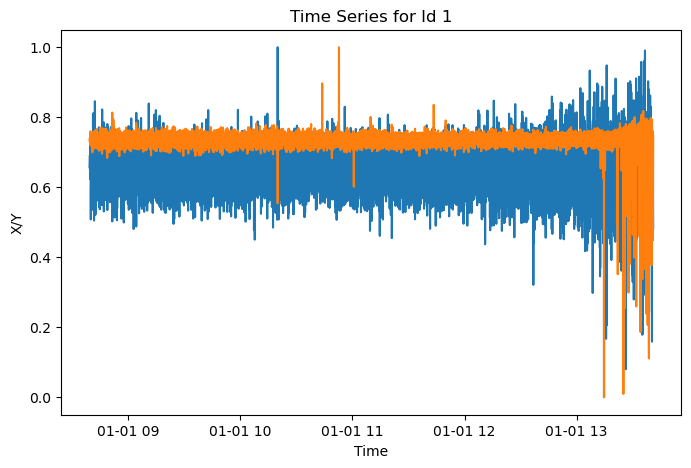

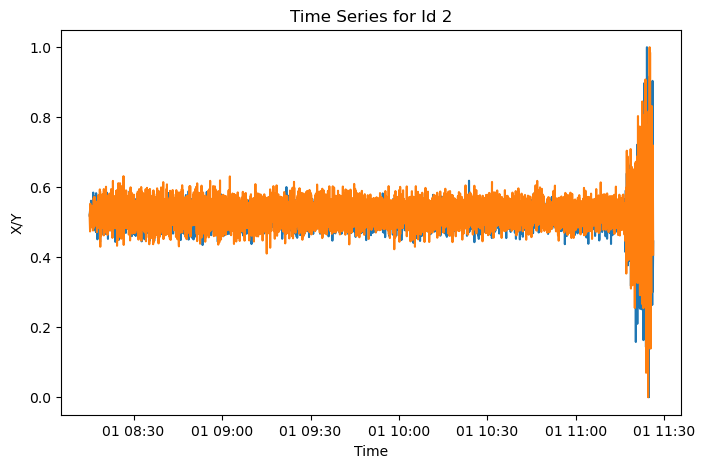

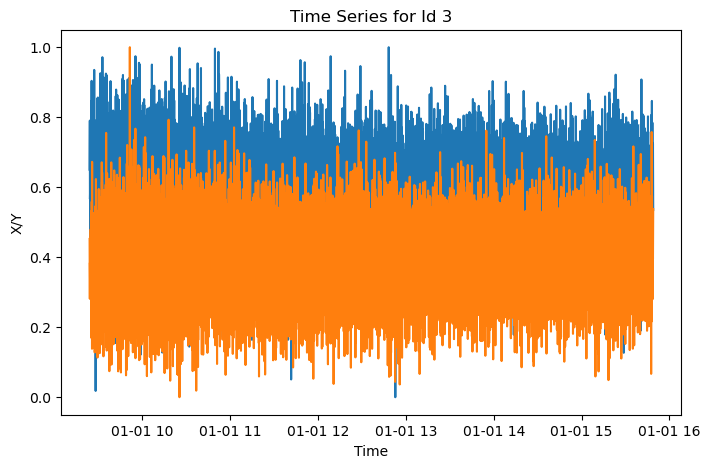

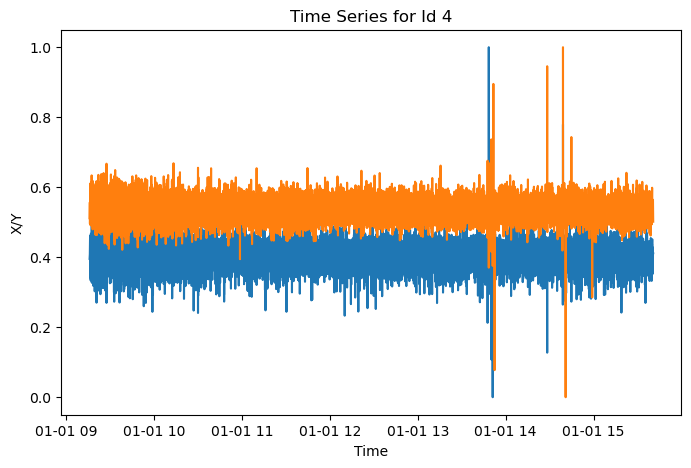

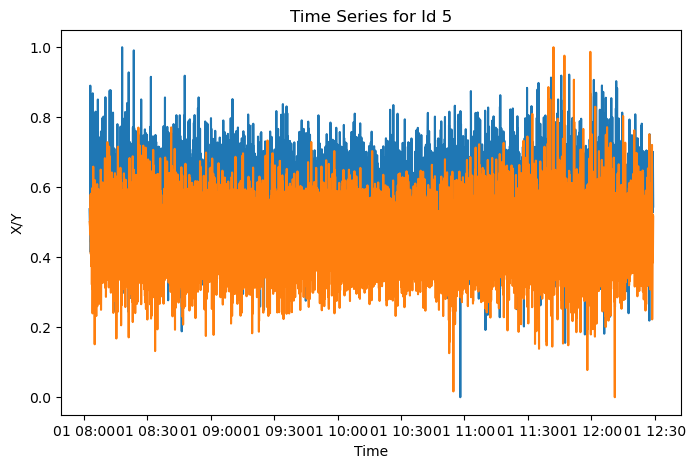

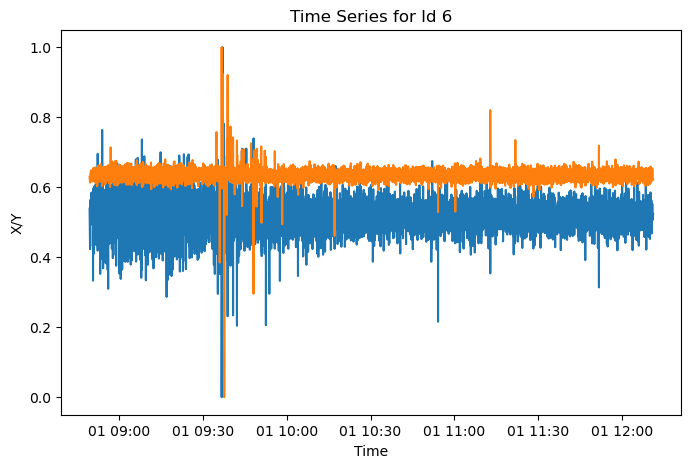

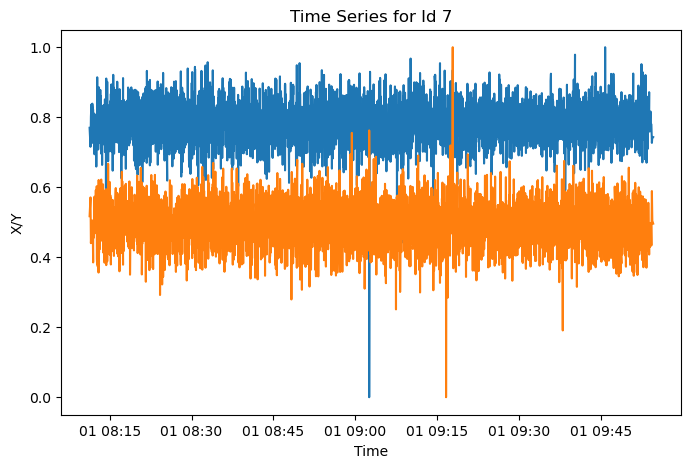

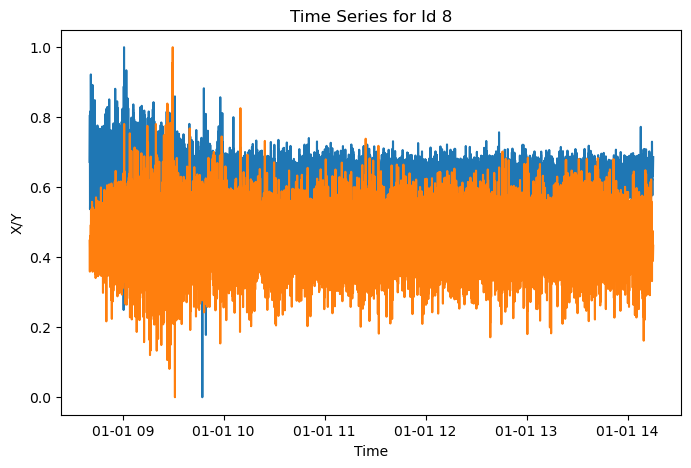

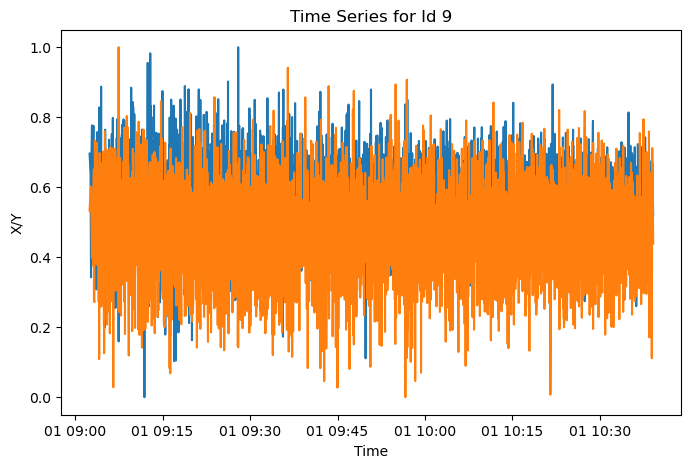

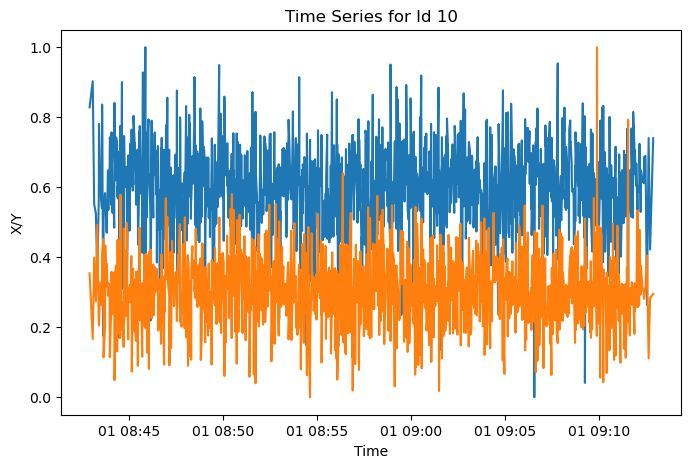

In [6]:
plot_data(df_s_test)

## Roll Data

In [ ]:
#TODO: Params festlegen
df_s_train_rolled   = roll_data(df_s_train, min_timeshift=1000, rolling_direction=800)
df_s_test_rolled    = roll_data(df_s_test, min_timeshift=1000, rolling_direction=800)
df_s_validate_rolled = roll_data(df_s_validate, min_timeshift=1000, rolling_direction=800)
df_t_train_rolled   = roll_data(df_t_train, min_timeshift=1000, rolling_direction=800)
df_t_test_rolled    = roll_data(df_t_test, min_timeshift=1000, rolling_direction=800)

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


## Feature Generation

In [ ]:
from tsfresh.feature_extraction import MinimalFCParameters

# TODO: Params festlegen
X_s_train = extract_features(df_s_train_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL', 'date_time_difference', 'max_date_time_difference']), column_id='id', column_sort='time', default_fc_parameters= MinimalFCParameters(), impute_function=impute)

## Feature Selection

In [80]:
y_s_train   = df_s_train_rolled['roll_RUL']
y_s_test    = df_s_test_rolled['roll_RUL']
y_s_validate = df_s_validate_rolled['roll_RUL']
y_t_train   = df_t_train_rolled['roll_RUL']
y_t_test    = df_t_test_rolled['roll_RUL']
y_s_train.index = df_s_train_rolled['id'].tolist()
y_s_test.index  = df_s_test_rolled['id'].tolist()
y_s_validate.index = df_s_validate_rolled['id'].tolist()
y_t_train.index = df_t_train_rolled['id'].tolist()
y_t_test.index = df_t_test_rolled['id'].tolist()
y_s_train_distinct  = y_s_train.groupby(level=0).last()
y_s_test_distinct   = y_s_test.groupby(level=0).last()
y_s_validate_distinct = y_s_validate.groupby(level=0).last()
y_t_train_distinct  = y_t_train.groupby(level=0).last()
y_t_test_distinct   = y_t_test.groupby(level=0).last()

In [81]:
#TODO: fdr_level festlegen
X_s_train_selected = select_features(X_s_train, y_s_train_distinct, ml_task='classification', show_warnings=True, fdr_level= 0.5)

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(
/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/tsfresh/feature_selection/relevance.py:337: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  table_binary["p_value"] = pd.Series(


In [65]:
X_s_train_selected

x__sum_values  y__sum_values  y__length  x__length  \
1 2023-01-01 10:10:07.910     523.889138     660.292405     1221.0     1221.0   
  2023-01-01 10:29:09.312     866.803800    1093.204544     2021.0     2021.0   
  2023-01-01 10:48:13.260    1209.892304    1525.291039     2821.0     2821.0   
  2023-01-01 11:07:14.664    1553.159237    1957.961519     3621.0     3621.0   
  2023-01-01 11:26:18.610    1896.520952    2390.868986     4421.0     4421.0   
  2023-01-01 11:45:22.550    2239.918157    2823.494090     5221.0     5221.0   
  2023-01-01 12:04:23.960    2583.105020    3255.893263     6021.0     6021.0   
  2023-01-01 12:23:27.910    2926.429773    3688.609088     6821.0     6821.0   
  2023-01-01 12:42:29.312    3269.073872    4121.354814     7621.0     7621.0   
  2023-01-01 13:01:33.260    3612.252491    4553.890944     8421.0     8421.0   
  2023-01-01 13:20:34.664    3955.371652    4985.979091     9221.0     9221.0   
  2023-01-01 13:39:38.610    4298.462477    5418.808325    10021.0    10021.0   
  2023-01-01 13:58:42.550    4641.263411    5850.998729    10821.0    10821.0   
  2023-01-01 14:17:43.960    4984.114411    6283.963330    11621.0    11621.0   
  2023-01-01 14:36:47.910    5326.991237    6716.334541    12421.0    12421.0   
  2023-01-01 14:55:49.312    5670.185881    7149.051065    13221.0    13221.0   
  2023-01-01 15:14:53.260    6013.539952    7581.109946    14021.0    14021.0   
  2023-01-01 15:33:54.664    6356.778821    8013.024944    14821.0    14821.0   
  2023-01-01 15:53:18.610    6699.820698    8445.934414    15621.0    15621.0   
  2023-01-01 16:12:22.550    7042.517403    8878.815952    16421.0    16421.0   
  2023-01-01 16:31:23.960    7385.239196    9311.769844    17221.0    17221.0   
  2023-01-01 16:50:27.910    7729.210559    9744.733397    18021.0    18021.0   
  2023-01-01 17:09:29.312    8072.597554   10177.933524    18821.0    18821.0   
  2023-01-01 17:29:12.550    8415.084846   10611.760788    19621.0    19621.0   
2 2023-01-01 09:20:05.160     657.920959     399.083794     1221.0     1221.0   
  2023-01-01 09:39:06.560    1089.458604     661.519387     2021.0     2021.0   
  2023-01-01 09:58:10.510    1520.093539     923.326302     2821.0     2821.0   
  2023-01-01 10:17:11.910    1950.884904    1185.009864     3621.0     3621.0   
  2023-01-01 10:36:15.860    2381.826593    1446.768073     4421.0     4421.0   
  2023-01-01 10:55:19.800    2812.952372    1707.196669     5221.0     5221.0   
  2023-01-01 11:14:21.210    3245.037009    1968.516110     6021.0     6021.0   
3 2023-01-01 08:58:42.660     586.793704     529.558397     1221.0     1221.0   
  2023-01-01 09:17:44.060     971.842041     876.356479     2021.0     2021.0   
  2023-01-01 09:36:48.010    1355.614646    1223.942052     2821.0     2821.0   
  2023-01-01 09:55:49.410    1741.950100    1571.777001     3621.0     3621.0   
  2023-01-01 10:14:53.360    2127.081045    1918.794985     4421.0     4421.0   
  2023-01-01 10:33:57.300    2509.554365    2268.877510     5221.0     5221.0   
  2023-01-01 10:52:58.710    2894.445747    2615.859127     6021.0     6021.0   

                            x__mean  y__minimum  y__median  \
1 2023-01-01 10:10:07.910  0.429066    0.494725   0.539816   
  2023-01-01 10:29:09.312  0.428898    0.494725   0.540292   
  2023-01-01 10:48:13.260  0.428888    0.490594   0.540102   
  2023-01-01 11:07:14.664  0.428931    0.455100   0.540229   
  2023-01-01 11:26:18.610  0.428980    0.455100   0.540356   
  2023-01-01 11:45:22.550  0.429021    0.455100   0.540451   
  2023-01-01 12:04:23.960  0.429016    0.455100   0.540515   
  2023-01-01 12:23:27.910  0.429032    0.455100   0.540578   
  2023-01-01 12:42:29.312  0.428956    0.455100   0.540578   
  2023-01-01 13:01:33.260  0.428958    0.455100   0.540610   
  2023-01-01 13:20:34.664  0.428953    0.019066   0.540642   
  2023-01-01 13:39:38.610  0.428945    0.019066   0.540737   
  2023-01-01 13:58:42.550  0.428913    0.019066   0.540674   

In [82]:
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_s_train_selected)
X_t_train_selected  = extract_features(df_t_train_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_t_test_selected  = extract_features(df_t_test_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_s_test_selected   = extract_features(df_s_test_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_s_validate_selected   = extract_features(df_s_validate_rolled.drop(columns=["RUL_cat", 'time_end', 'bearing_id', 'RUL', 'roll_RUL', 'value_RUL']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


## Data Processing

## Daten

In [67]:
Xs_train    = X_s_train_selected
Xs_test     = X_s_test_selected[Xs_train.columns]
Xs_val      = X_s_validate_selected[Xs_train.columns]
Xt_train    = X_t_train_selected[Xs_train.columns]
Xt_test     = X_s_test_selected[Xs_train.columns]
ys_train    = y_s_train_distinct
ys_test     = y_s_test_distinct
ys_val      = y_s_validate_distinct
yt_train    = y_t_train_distinct
yt_test     = y_t_test_distinct

## Hyperparameter Optimization

In [68]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=3
                                    )

forest_bayes_search.fit(Xs_train, ys_train) # callback=on_step will print score after each iteration

best_params = forest_bayes_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = forest_bayes_search.best_estimator_
accuracy = best_model.score(Xs_val, ys_val)
print("Accuracy on Validation Data:", accuracy)

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Hyperparameters: OrderedDict([('bootstrap', False), ('max_depth', 9), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 75)])
Accuracy on Validation Data: 0.75


## Training

In [1]:
model = FA(forest_bayes_search.best_estimator_, Xt=Xt_train[:-6], yt=yt_train[:-6], random_state=0)

model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)
print(classification_report(yt_train, model.predict(Xt_train)))

NameError: name 'FA' is not defined

# Spielplatz

In [ ]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, #cv=2
                                    )

forest_bayes_search.fit(Xs_test, ys_test) # callback=on_step will print score after each iteration

In [ ]:
forest_bayes_search.best_score_

## Daten

In [83]:
Xs_train    = X_s_train_selected
Xs_test     = X_s_test_selected[Xs_train.columns]
Xs_val      = X_s_validate_selected[Xs_train.columns]
Xt_train    = X_t_train_selected[Xs_train.columns]
Xt_test     = X_t_test_selected[Xs_train.columns]
ys_train    = y_s_train_distinct
ys_test     = y_s_test_distinct
ys_val      = y_s_validate_distinct
yt_train    = y_t_train_distinct
yt_test     = y_t_test_distinct


## Modelstruktur

In [84]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

## Hyperparameteroptimierung Source Domain

In [85]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=3
                                    )

forest_bayes_search.fit(Xs_train, ys_train) # callback=on_step will print score after each iteration

best_params = forest_bayes_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = forest_bayes_search.best_estimator_
accuracy = best_model.score(Xs_val, ys_val)
print("Accuracy on Validation Data:", accuracy)

Best Hyperparameters: OrderedDict([('bootstrap', False), ('max_depth', 19), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 117)])
Accuracy on Validation Data: 0.7


## Transfer Learning

In [87]:
model = FA(forest_bayes_search.best_estimator_, Xt=Xt_train, yt=yt_train, random_state=0)

model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)

Fit transform...
Previous shape: (44, 6)
New shape: (62, 18)
Fit Estimator...


1.0

In [52]:
Xt_train

x__sum_values  y__sum_values  y__length  x__length  \
1 2023-01-01 09:38:27.790     482.373222     609.042254     1059.0     1059.0   
  2023-01-01 09:57:31.730     847.027428    1069.346217     1859.0     1859.0   
  2023-01-01 10:16:35.680    1213.420358    1529.622885     2659.0     2659.0   
  2023-01-01 10:35:37.080    1574.684884    1991.136369     3459.0     3459.0   
2 2023-01-01 09:04:58.054     704.823034     561.670557     1059.0     1059.0   
  2023-01-01 09:23:59.160    1237.852559     986.423887     1859.0     1859.0   
  2023-01-01 09:43:03.406    1771.874532    1409.497924     2659.0     2659.0   
  2023-01-01 10:02:04.109    2304.736205    1833.201776     3459.0     3459.0   
  2023-01-01 10:21:08.757    2836.231149    2257.083632     4259.0     4259.0   
  2023-01-01 10:40:09.460    3368.427653    2681.377775     5059.0     5059.0   
  2023-01-01 10:59:13.810    3900.083958    3105.009881     5859.0     5859.0   
  2023-01-01 11:18:18.054    4432.258489    3530.194114     6659.0     6659.0   
  2023-01-01 11:37:19.160    4964.650062    3954.107404     7459.0     7459.0   
  2023-01-01 11:56:23.406    5497.245506    4377.361950     8259.0     8259.0   
  2023-01-01 12:15:24.109    6029.517041    4801.660891     9059.0     9059.0   
  2023-01-01 12:34:28.757    6562.428839    5225.751754     9859.0     9859.0   
  2023-01-01 12:53:29.460    7094.952122    5651.298869    10659.0    10659.0   
  2023-01-01 13:23:53.810    7628.410112    6073.006229    11459.0    11459.0   

                            x__mean  y__minimum  y__median  \
1 2023-01-01 09:38:27.790  0.455499    0.445791   0.574189   
  2023-01-01 09:57:31.730  0.455636    0.414019   0.574954   
  2023-01-01 10:16:35.680  0.456345    0.414019   0.575500   
  2023-01-01 10:35:37.080  0.455243    0.212469   0.576264   
2 2023-01-01 09:04:58.054  0.665555    0.439997   0.530216   
  2023-01-01 09:23:59.160  0.665870    0.439997   0.530216   
  2023-01-01 09:43:03.406  0.666369    0.439997   0.529858   
  2023-01-01 10:02:04.109  0.666301    0.439997   0.529715   
  2023-01-01 10:21:08.757  0.665938    0.424746   0.529787   
  2023-01-01 10:40:09.460  0.665829    0.424746   0.530001   
  2023-01-01 10:59:13.810  0.665657    0.424746   0.529930   
  2023-01-01 11:18:18.054  0.665604    0.424746   0.530145   
  2023-01-01 11:37:19.160  0.665592    0.424746   0.530073   
  2023-01-01 11:56:23.406  0.665607    0.424746   0.530001   
  2023-01-01 12:15:24.109  0.665583    0.424746   0.530001   
  2023-01-01 12:34:28.757  0.665628    0.424746   0.530073   
  2023-01-01 12:53:29.460  0.665630    0.305385   0.530073   
  2023-01-01 13:23:53.810  0.665713    0.000000   0.530073   

                           y__root_mean_square   y__mean  
1 2023-01-01 09:38:27.790             0.576106  0.575111  
  2023-01-01 09:57:31.730             0.576279  0.575227  
  2023-01-01 10:16:35.680             0.576317  0.575262  
  2023-01-01 10:35:37.080             0.576730  0.575639  
2 2023-01-01 09:04:58.054             0.530852  0.530378  
  2023-01-01 09:23:59.160             0.531081  0.530621  
  2023-01-01 09:43:03.406             0.530545  0.530086  
  2023-01-01 10:02:04.109             0.530429  0.529980  
  2023-01-01 10:21:08.757             0.530396  0.529956  
  2023-01-01 10:40:09.460             0.530444  0.530021  
  2023-01-01 10:59:13.810             0.530368  0.529956  
  2023-01-01 11:18:18.054             0.530546  0.530139  
  2023-01-01 11:37:19.160             0.530517  0.530112  
  2023-01-01 11:56:23.406             0.530417  0.530011  
  2023-01-01 12:15:24.109             0.530445  0.530043  
  2023-01-01 12:34:28.757             0.530448  0.530049  
  2023-01-01 12:53:29.460             0.530636  0.530190  
  2023-01-01 13:23:53.810             0.530602  0.529977

# Playground Time Series Segmentation

In [1]:
from my_package.utils import return_df
from my_package.utils import create_df, plot_data, return_df, roll_data, norm
from sklearn.preprocessing import StandardScaler
dir_data = '../data.nosync/'

data_s_train_1    = ['train/Bearing1_1']
data_s_train_2    = ['train/Bearing1_2']
df_s_train_1      = return_df(dir_data, data_s_train_1)
df_s_train_2        = return_df(dir_data, data_s_train_2)
data_s_test_3     = ['test/Bearing2_3']
data_s_test_4   =  ['test/Bearing2_4']
data_s_test_5 = ['test/Bearing2_5']
data_s_test_6 = ['test/Bearing2_6']
df_s_test_3   = return_df(dir_data, data_s_test_3)
df_s_test_4    = return_df(dir_data, data_s_test_4)
df_s_test_5    = return_df(dir_data, data_s_test_5)
df_s_test_6    = return_df(dir_data, data_s_test_6)
df_s_train_1 = norm(df_s_train_1)
df_s_train_2 = norm(df_s_train_2)
df_s_test_3 = norm(df_s_test_3)
df_s_test_4 = norm(df_s_test_4)
df_s_test_5 = norm(df_s_test_5)
df_s_test_6 = norm(df_s_test_6)

scaler = StandardScaler()

# Fit and transform the 'x' column
df_s_test_3['x'] = scaler.fit_transform(df_s_test_3[['x']])
df_s_test_3['y'] = scaler.fit_transform(df_s_test_3[['y']])
df_s_test_5['x'] = scaler.fit_transform(df_s_test_5[['x']])
df_s_test_5['y'] = scaler.fit_transform(df_s_test_5[['y']])
df_s_test_6['x'] = scaler.fit_transform(df_s_test_6[['x']])
df_s_test_6['y'] = scaler.fit_transform(df_s_test_6[['y']])
df_s_test_4['x'] = scaler.fit_transform(df_s_test_4[['x']])
df_s_test_4['y'] = scaler.fit_transform(df_s_test_4[['y']])
df_s_train_1['x'] = scaler.fit_transform(df_s_train_1[['x']])
df_s_train_1['y'] = scaler.fit_transform(df_s_train_1[['y']])
df_s_train_2['x'] = scaler.fit_transform(df_s_train_2[['x']])
df_s_train_2['y'] = scaler.fit_transform(df_s_train_2[['y']])

df_list = [df_s_train_1, df_s_train_2, df_s_test_3, df_s_test_4, df_s_test_5, df_s_test_6]

/Users/felixschreyer/Documents/Dokumente/Abschlussarbeit/Notebooks/src/my_package/utils.py:142: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normalized_df = df.groupby('id').apply(normalize_group)
/Users/felixschreyer/Documents/Dokumente/Abschlussarbeit/Notebooks/src/my_package/utils.py:142: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, 

/Users/felixschreyer/anaconda3/envs/Testing/lib/python3.11/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


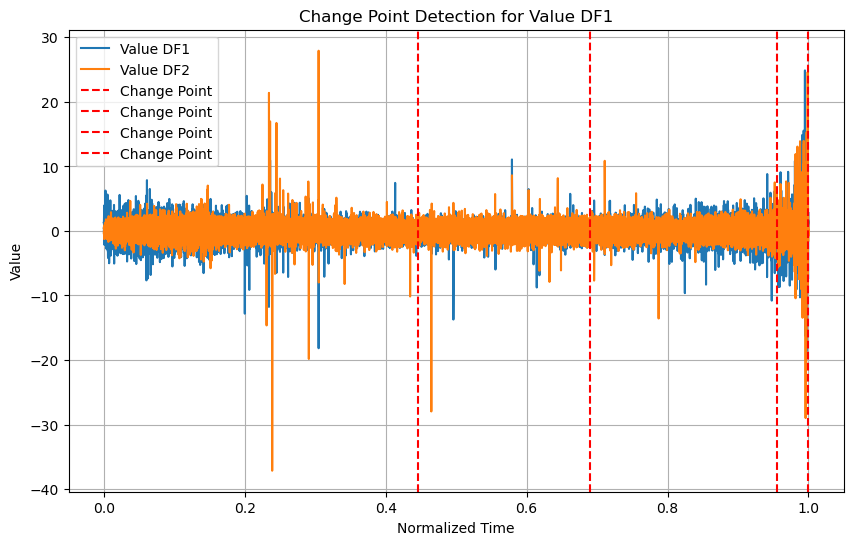

KeyError: 'RUL'

In [2]:
from my_package.segmentation import segment

segment(df_list)